<a href="https://colab.research.google.com/github/kapil-4944/cvpr25/blob/main/Kapil_Frinks_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data loading
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize,medial_axis

In [ ]:
#### Morphological Operations

kernel = np.ones((3,3),np.uint8)

def erosion(kernel,image,iterations):
  erode_img = cv2.erode(image,kernel,iterations)
  return erode_img
def dilation(kernel,image,iterations):
  dilated_img = cv2.dilate(image, kernel,iterations)
  return dilated_img

def opening(kernel,img):
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  return opening
def closing(kernel,img):
  closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  return closing



## preprocessing
# gaussian blur
def bilateral_filter(image,params):
  out_img = cv2.bilateralFilter(image,params[0],params[1],params[2])
  return out_img

def gaussian_blur(image,gauss_params):
  out_img = cv2.GaussianBlur(image,gauss_params[0],gauss_params[1])
  return out_img

Q1: DataLoading

In [ ]:
###   connected component analysis ###

def dfs(image, y, x, visited, component, target_value):
    """Depth-First Search to find all pixels connected to (y, x)."""
    stack = [(y, x)]  # Initialize stack with the seed point

    while stack:
        cy, cx = stack.pop()

        if visited[cy, cx]:  # Skip if already visited
            continue

        visited[cy, cx] = True  # Mark as visited
        component[cy, cx] = 255  # Add to the connected component

        # Check 8-connected neighbors
        neighbors = [
            (cy-1, cx-1), (cy-1, cx), (cy-1, cx+1),
            (cy, cx-1),              (cy, cx+1),
            (cy+1, cx-1), (cy+1, cx), (cy+1, cx+1)
        ]

        for ny, nx in neighbors:
            if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]:  # Within bounds
                # print("heheheh")
                if image[ny, nx] == target_value and not visited[ny, nx]:  # Same region and not visited
                    # print("hahahaha")
                    stack.append((ny, nx))  # Add to stack

def extract_connected_component(image, seed_points):
    """Extracts the connected component from a binary image using DFS."""
    h, w = image.shape
    visited = np.zeros((h, w), dtype=bool)
    component = np.zeros((h, w), dtype=np.uint8)

    for y,x in zip(seed_points[0],seed_points[1]):
      # print(x,y)
      if image[y, x] == 255:  # Check if seed is inside an object
          # print("dfs started")
          dfs(image, y, x, visited, component, target_value=255)

    return component

In [ ]:
## question 1 dataloading
root_dirpath ="/content/drive/MyDrive/Frinks"
results_path = os.path.join(root_dirpath,"results")
data_dirpath = os.path.join(root_dirpath,"q1_folder")
raw_dirpath = os.path.join(data_dirpath,"raw")
masks_dirpath = os.path.join(data_dirpath,"masks")

def read_images(path,cnvt_binary=False):
  images = []
  for image_path in glob.glob(f'{path}/*'):
    print(os.path.exists(image_path),image_path)
    img = cv2.imread(image_path)
    if cnvt_binary:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)
  return images

raw_images = read_images(raw_dirpath,True)
masks_images = read_images(masks_dirpath,True)
raw_images_rgb = read_images(raw_dirpath)

True /content/drive/MyDrive/Frinks/q1_folder/raw/1_narrow_1731758745745_raw.png
True /content/drive/MyDrive/Frinks/q1_folder/raw/1_expanded_1731922760724_raw.png
True /content/drive/MyDrive/Frinks/q1_folder/raw/1_good_1732015836251_raw.png
True /content/drive/MyDrive/Frinks/q1_folder/masks/2_1742794181179_1_segmask.png
True /content/drive/MyDrive/Frinks/q1_folder/masks/2_1742794183440_1_segmask.png
True /content/drive/MyDrive/Frinks/q1_folder/masks/2_1742794184146_1_segmask.png
True /content/drive/MyDrive/Frinks/q1_folder/raw/1_narrow_1731758745745_raw.png
True /content/drive/MyDrive/Frinks/q1_folder/raw/1_expanded_1731922760724_raw.png
True /content/drive/MyDrive/Frinks/q1_folder/raw/1_good_1732015836251_raw.png


Preprocessing

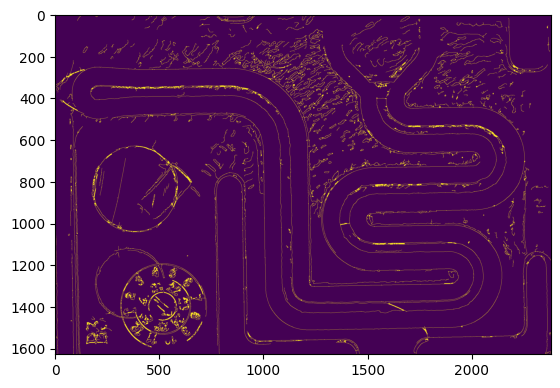

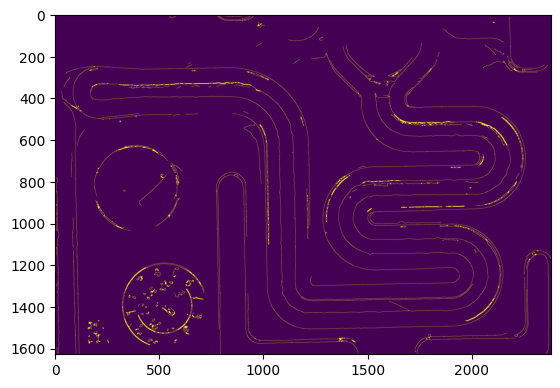

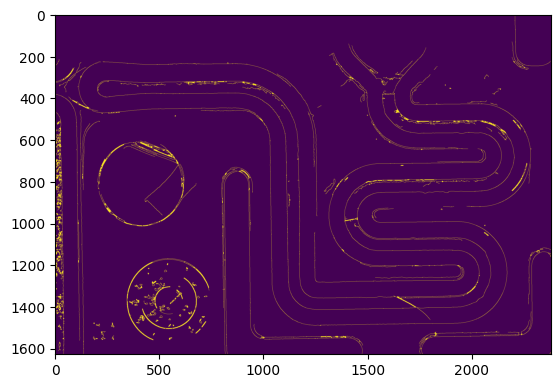

In [ ]:
gaussian_param = [(5,5),0]
G_blurred_img = []
edges=[]
edges_mask = []
for i in range(len(raw_images)):
  b1 = gaussian_blur(raw_images[i],gaussian_param)
  G_blurred_img.append(b1)

  # edge detection
  edge = cv2.Canny(b1, 50, 150)
  # dilation to close the small holes in edge maps
  edge = closing(kernel,edge)
  edges.append(edge)
  edges_mask1 = masks_images[i]
  edges_mask.append(edges_mask1)

  plt.imshow(edge)
  plt.show()


# Connected Components in edge map
(only where given mask and edge map is True)

312
(1628, 2380)
10831


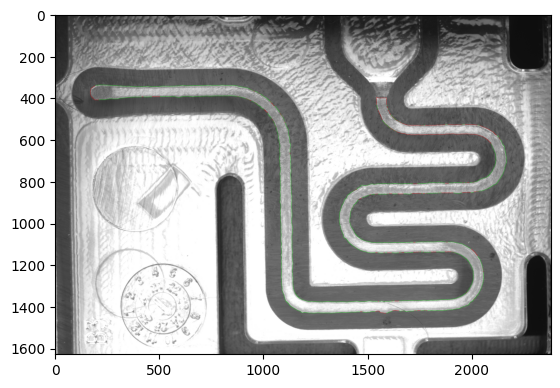

157
(1628, 2380)
11004


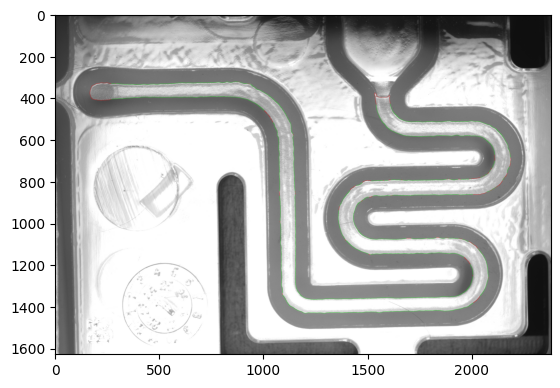

139
(1628, 2380)
10895


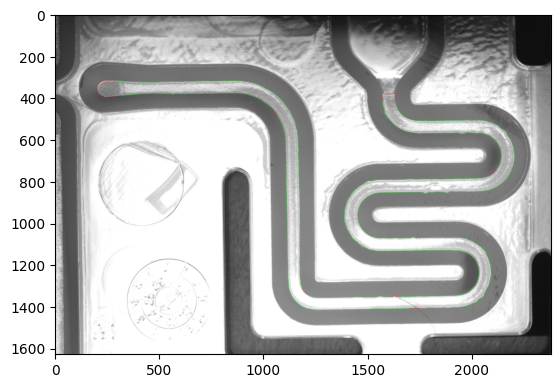

In [ ]:
raw_images_rgb_temp = raw_images_rgb
connected_components=[]
contour_imgs = []
skeletons = []
a_s = []
for j in range(len(edges)):
  c1 = extract_connected_component(edges[j], np.where(edges[j]*edges_mask[j]>0))
  closing_img = (dilation(kernel,c1,1))
  contours, _ = cv2.findContours(closing_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  print(len(contours))
  largest_contour = max(contours, key=cv2.contourArea)

  a = np.zeros_like(edges[j])
  contour_img = cv2.drawContours(a,[largest_contour],contourIdx=-1, color=1, thickness=-1)

  contour_imgs.append(contour_img)
  connected_components.append(c1)

  ## 2 time dilation 2 time erision to remove extra branches nearby
  a = dilation(kernel,dilation(kernel,erosion(kernel,erosion(kernel,a.astype(np.uint8),1),1),1),1)
  print(a.shape)
  a_s.append(a)


  skeleton,distance = medial_axis(a>0, return_distance=True)
  skeleton = skeleton.astype(np.uint8)
  # skeleton_points = np.column_stack(np.where(skeleton > 0))


  skeletons.append(skeleton)
  edge_a = cv2.Canny(a*255, 50, 150)
  e = np.where(edge_a>0)

  skeleton_inv = 1 - skeleton
#   # The distance transform here gives, for each pixel, the Euclidean distance to the nearest skeleton pixel.
  dist_from_skel = cv2.distanceTransform(skeleton_inv.astype(np.uint8), cv2.DIST_L2, 5)
  contour_distances = []
  xx = np.zeros_like(raw_images_rgb_temp[j])
  for x, y in zip(e[0],e[1]):
      #  = pt  # note: pt is [x, y]
      contour_distances.append(2*dist_from_skel[x,y])
      raw_images_rgb_temp[j][x,y] = [255, 0, 0] if int(2*dist_from_skel[x,y])>74 or int(2*dist_from_skel[x,y])<47 else [0, 255, 0]
  contour_distances = np.array(contour_distances)

  ## save the output images
  # os.mkdir(os.path.join(data_dirpath,"test"))
  os.chdir(os.path.join(results_path))
  cv2.imwrite(f"annotation{j}.png",cv2.cvtColor(raw_images_rgb_temp[j], cv2.COLOR_BGR2RGB))
  cv2.imwrite(f"edge{j}.png",cv2.cvtColor(edge_a, cv2.COLOR_GRAY2RGB))
  mask  = (edge_a == 255)
  print(mask.sum())
  # raw_images_rgb_temp[j][mask] = [255, 0, 0]
  plt.imshow(raw_images_rgb_temp[j])
  plt.show()




# Question2



Dataloading

In [ ]:
## question 2
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# root_dirpath ="/content/drive/MyDrive/Frinks"
results_path = os.path.join(root_dirpath,"results")
data_dirpath = os.path.join(root_dirpath,"q2_folder")
targets_dirpath = os.path.join(data_dirpath,"targets")
templates_dirpath = os.path.join(data_dirpath,"templates")

# create results_path
os.makedirs(results_path, exist_ok=True)

def read_images(path,cnvt_binary=False):
  images = []
  for image_path in glob.glob(f'{path}/*'):
    print(os.path.exists(image_path),image_path)
    img = cv2.imread(image_path)
    if cnvt_binary:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)
  return images
templates_images= read_images(templates_dirpath,True)
targets_images = read_images(targets_dirpath,True)
print(len(templates_images),len(targets_images))

True /content/drive/MyDrive/Frinks/q2_folder/templates/c4.png
True /content/drive/MyDrive/Frinks/q2_folder/templates/h2.png
True /content/drive/MyDrive/Frinks/q2_folder/templates/h1.png
True /content/drive/MyDrive/Frinks/q2_folder/targets/Image_2410.bmp
True /content/drive/MyDrive/Frinks/q2_folder/targets/Image_2243.bmp
True /content/drive/MyDrive/Frinks/q2_folder/targets/Image_2392.bmp
3 3



Affine Transformation function for augmention data



In [ ]:

def affine_skew_1(tilt, phi, img, mask=None):
    '''
    affine_skew(tilt, phi, img, mask=None) -> skew_img, skew_mask, Ai

    Ai - is an affine transform matrix from skew_img to img
    '''
    h, w = img.shape[:2]
    if mask is None:
        mask = np.zeros((h, w), np.uint8)
        mask[:] = 255
    A = np.float32([[1, 0, 0], [0, 1, 0]])
    if phi != 0.0:
        phi = np.deg2rad(phi)
        s, c = np.sin(phi), np.cos(phi)
        A = np.float32([[c,-s], [ s, c]])
        corners = [[0, 0], [w, 0], [w, h], [0, h]]
        tcorners = np.int32( np.dot(corners, A.T) )
        x, y, w, h = cv2.boundingRect(tcorners.reshape(1,-1,2))
        A = np.hstack([A, [[-x], [-y]]])
        img = cv2.warpAffine(img, A, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    if tilt != 1.0:
        s = 0.8*np.sqrt(tilt*tilt-1)
        img = cv2.GaussianBlur(img, (3, 3), sigmaX=s, sigmaY=0.01)
        img = cv2.resize(img, (0, 0), fx=1.0/tilt, fy=1.0, interpolation=cv2.INTER_NEAREST)
        A[0] /= tilt
    if phi != 0.0 or tilt != 1.0:
        h, w = img.shape[:2]
        mask = cv2.warpAffine(mask, A, (w, h), flags=cv2.INTER_NEAREST)
    Ai = cv2.invertAffineTransform(A)
    return img, mask, Ai

# Template Matching Method

0.0


<ipython-input-7-01695d46871b>:22: RuntimeWarning: invalid value encountered in sqrt
  s = 0.8*np.sqrt(tilt*tilt-1)


120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1953, 2964)
(433,) (433,) 2


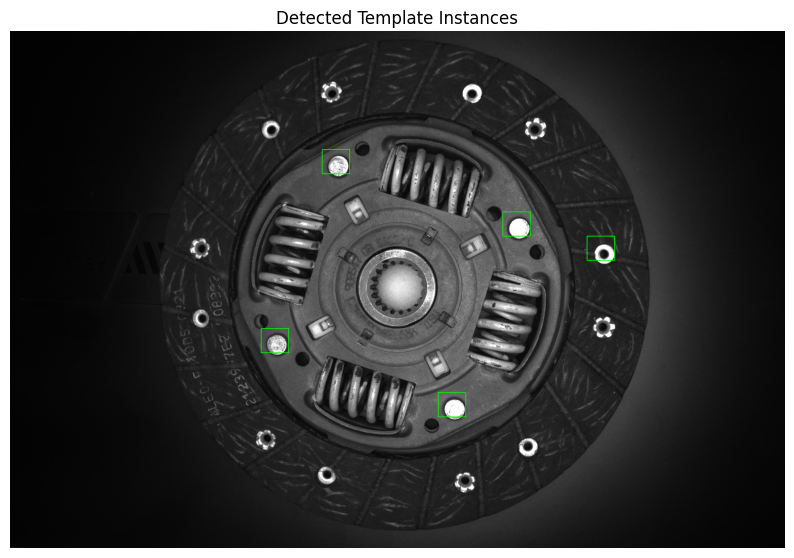

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1956, 2980)
(159,) (159,) 2


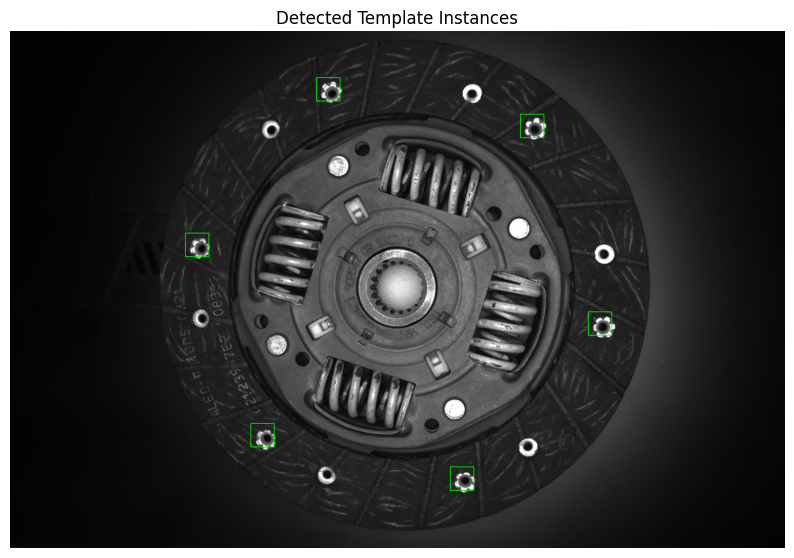

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1663, 2814)
(0,) (0,) 2


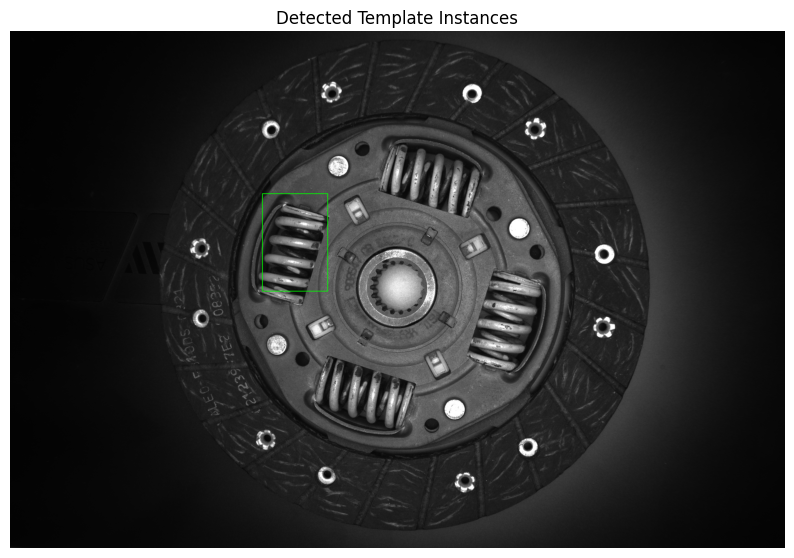

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1953, 2964)
(405,) (405,) 2


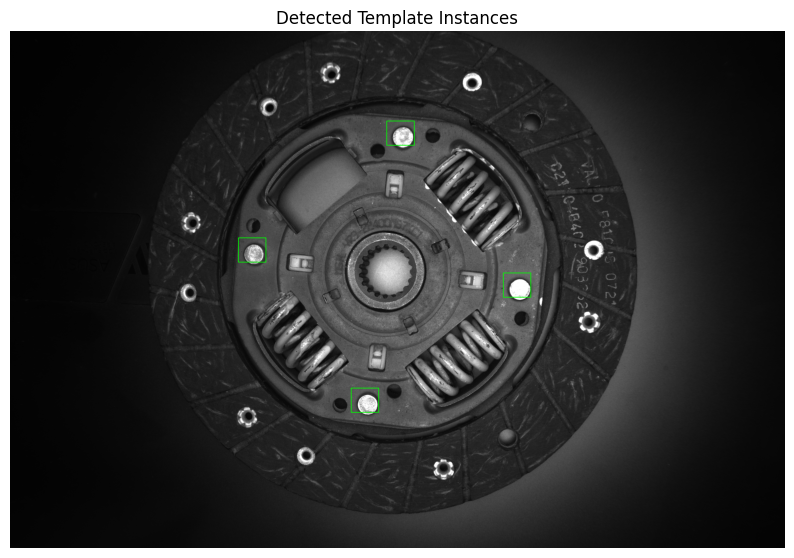

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1956, 2980)
(0,) (0,) 2


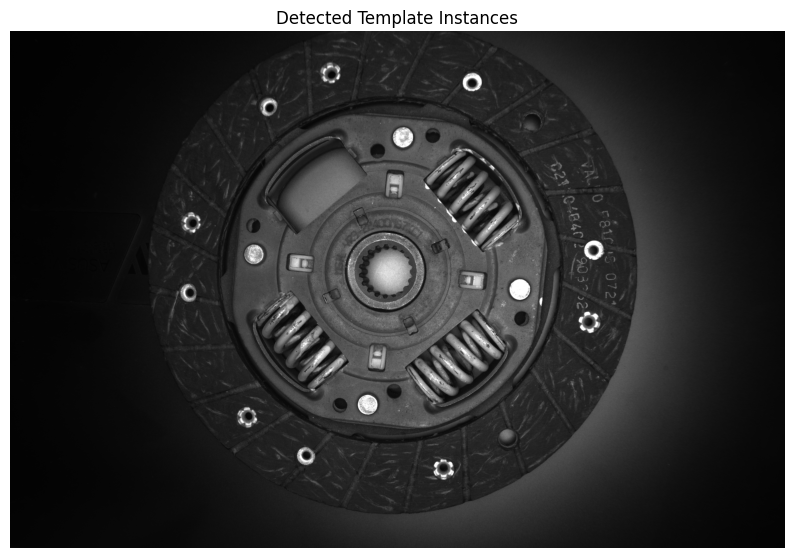

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1663, 2814)
(0,) (0,) 2


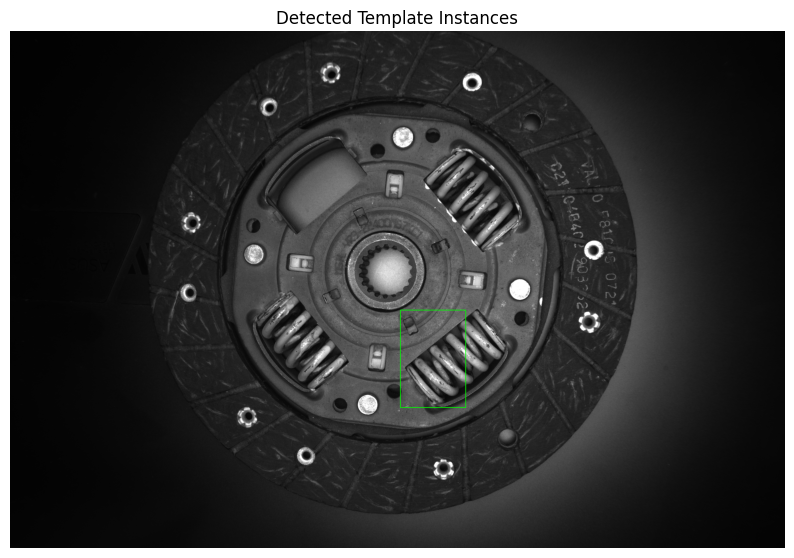

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1953, 2964)
(475,) (475,) 2


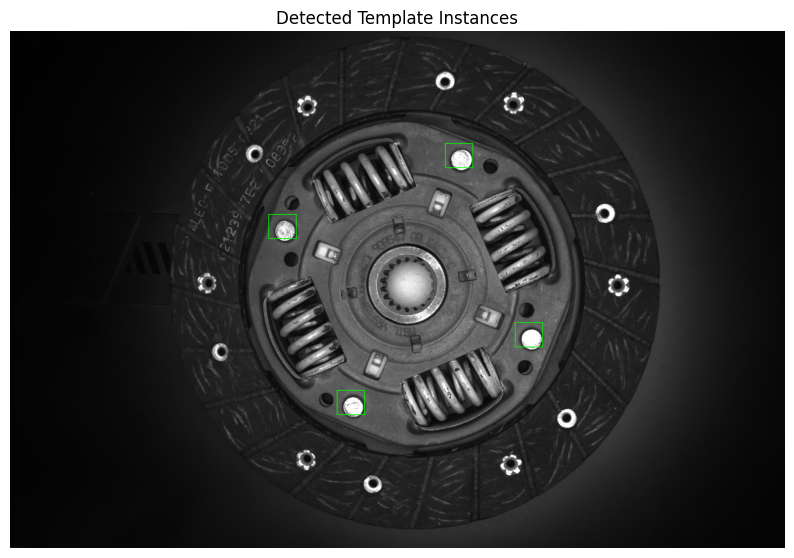

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1956, 2980)
(67,) (67,) 2


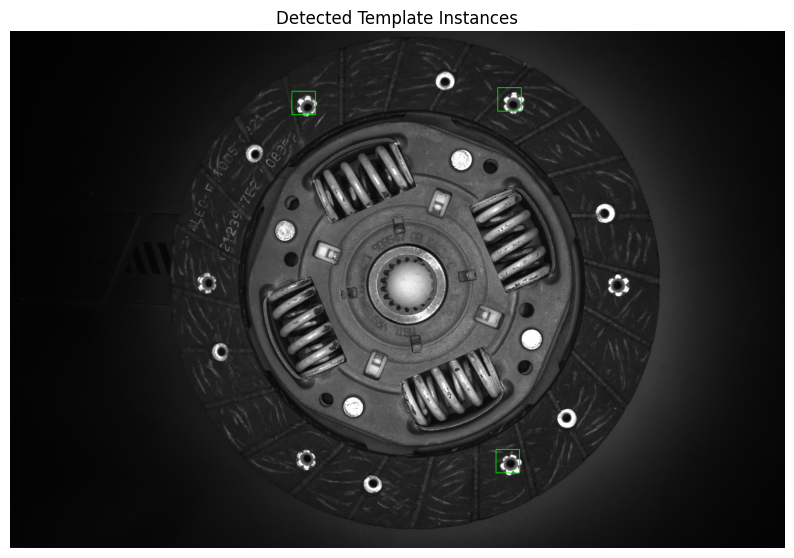

0.0
120.0
240.0
0.0
60.0
120.0
180.0
240.0
300.0
0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0
(1663, 2814)
(0,) (0,) 2


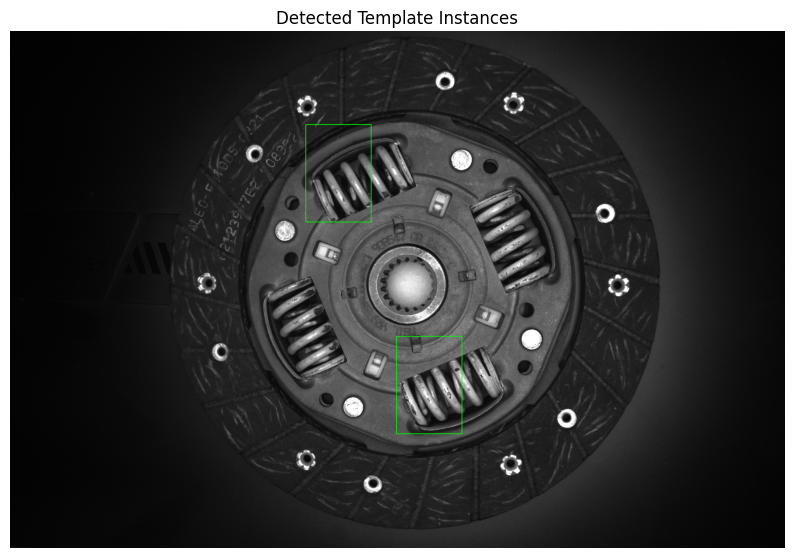

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# save the files in "results" dir
# results_path  naming is template_1_results
# Load the target image and template in grayscale
for j in range(len(targets_images)):
  for i in range(len(templates_images)):
    temp_str = f"template_{i+1}_results"
    temp_path = os.path.join(results_path,temp_str)
    if not os.path.exists(temp_path):
      os.makedirs(temp_path, exist_ok=True)
    # save the image with name j+1
    target_str = f"target_{j+1}.png"
    # change working dir
    os.chdir(temp_path)
    target_path = os.path.join(temp_path,target_str)


    os.makedirs(temp_path, exist_ok=True)
    img = targets_images[j]
    template = templates_images[i]
    template_h, template_w = template.shape[:2]
    # threshold to find locations with high correlation scores
    threshold = 0.75 if i !=2 else .5


    ## get rotated versions of template
    affined_templates = []
    affine_locs =[]
    params = [(1.0, 0.0)]
    for t in [0.5,1,1.5,2]:
        for phi in np.arange(0, 360, 60 / t):
            print(phi)
            params.append((t, phi))
            timg, tmask, Ai = affine_skew_1(t, phi, template)
            affined_templates.append(timg)
            result = cv2.matchTemplate(img, timg, cv2.TM_CCOEFF_NORMED)
            loc = np.where(result >= threshold)
            affine_locs.append(loc)

    # Apply template matching using normalized cross-correlation
    result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    print(result.shape)


    loc = np.where(result >= threshold)


    # Create a list of rectangles (x, y, width, height)
    rectangles = []
    print(loc[0].shape,loc[0].shape,len(loc))
    for loc in affine_locs:
      for pt in zip(*loc[::-1]):  # swap x and y coordinates
          rect = [int(pt[0]), int(pt[1]), template_w, template_h]
          rectangles.append(rect)
        # Also add a duplicate rectangle to help groupRectangles function (it requires at least two rectangles to group)
        # rectangles.append(rect)

    # Apply non-maximum suppression using cv2.groupRectangles
    # groupThreshold: Minimum number of rectangles to group together.
    # eps: Relative difference between rectangles to merge them.
    rectangles, weights = cv2.groupRectangles(rectangles, groupThreshold=1, eps=0.5)

    # Draw the final bounding boxes on the image
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in rectangles:
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the result
    cv2.imwrite(target_path,img_color)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title("Detected Template Instances")
    plt.axis("off")
    plt.show()
